In [2]:
import os
import glob
import re
from pathlib import Path

from operator import itemgetter
import natsort
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'figure.dpi': 200, 'figure.autolayout': True})

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

#!pip install hdbscan
#from hdbscan import HDBSCAN
#from hdbscan.validity import validity_index

from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

np.set_printoptions(suppress=True, precision = 3)

In [3]:
SAMPLE_DICT_DATA_KEY = "data"
SAMPLE_DICT_NAME_KEY = "name"
SAMPLE_DICT_CLASS_ID_KEY = "class_id"
SAMPLE_DICT_PATIENT_ID_KEY = "patient_id"
SAMPLE_DICT_TSNE_KEY = "tsne"
SAMPLE_DICT_PCA_KEY = "pca"

# Note! This code assumes there is a folder called data, wherein all data versions are stored
RAW_RAMAN_DATA_PATH = "../data/raw"
CORRECTED_DATA_NPY_PATH = "../data/preprocessed"
CLUSTERING_OUTPUT_DIR = "../data/tumor_separation"
TUMOR_MAPS_PATH = "../data/tumor_maps"

#OUTPUT_FIGS_FORMAT = "tiff"
OUTPUT_FIGS_FORMAT = "png"

AIRPLS_LAMBDA = 4
AIRPLS_PORDER = 1

# Library 

### Baseline Correction - AirPLS
source: https://github.com/zmzhang/airPLS/blob/master/airPLS.py

In [4]:
'''
airPLS.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
Baseline correction using adaptive iteratively reweighted penalized least squares
This program is a translation in python of the R source code of airPLS version 2.0
by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
Reference:
Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively 
reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).
Description from the original documentation:
Baseline drift always blurs or even swamps signals and deteriorates analytical 
results, particularly in multivariate analysis.  It is necessary to correct baseline 
drift to perform further data analysis. Simple or modified polynomial fitting has 
been found to be effective in some extent. However, this method requires user 
intervention and prone to variability especially in low signal-to-noise ratio 
environments. The proposed adaptive iteratively reweighted Penalized Least Squares
(airPLS) algorithm doesn't require any user intervention and prior information, 
such as detected peaks. It iteratively changes weights of sum squares errors (SSE) 
between the fitted baseline and original signals, and the weights of SSE are obtained 
adaptively using between previously fitted baseline and original signals. This 
baseline estimator is general, fast and flexible in fitting baseline.
LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.
You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
'''

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is, 
                 the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,
                 the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z

# Utils

## Read raw raman spectra npy files

In [5]:
def read_raw_npy_file(path, verbose=False):
    
    from sys import platform
    if platform == "linux" or platform == "linux2":
        # linux
        match = re.search("^.*LGm-(?P<class_id>\d)\/HF-(?P<patient_id>\d+)_.*.npy$", path)        
    elif platform == "darwin":
        # OS X
        match = re.search("^.*LGm-(?P<class_id>\d)\/HF-(?P<patient_id>\d+)_.*.npy$", path)
    elif platform == "win32":
        # Windows
        match = re.search("^.*LGm-(?P<class_id>\d)\\\\HF-(?P<patient_id>\d+)_.*.npy$", path)
    else:
        # Use linux convention
        match = re.search("^.*LGm-(?P<class_id>\d)\/HF-(?P<patient_id>\d+)_.*.npy$", path)

    sample_data = np.load(path) #.astype(np.float32)
    sample_name = Path(path).stem
    patient_id = int(match.group("patient_id"))
    class_id = int(match.group("class_id"))

    if verbose:
        print(sample_name, class_id, patient_id, sample_data.shape)

    return {
        SAMPLE_DICT_DATA_KEY: sample_data, 
        SAMPLE_DICT_NAME_KEY: sample_name,
        SAMPLE_DICT_CLASS_ID_KEY: class_id,
        SAMPLE_DICT_PATIENT_ID_KEY: patient_id,
    }


def read_raw_samples_npy(base_csv_data_path, verbose=False):
    paths = glob.glob(os.path.join(base_csv_data_path, "LGm*/*.npy"), recursive=True)
    samples = [read_raw_npy_file(path, verbose=verbose) for path in paths]

    return samples


In [6]:
def median_spectrum(samples):
    spectra_list = [sample[SAMPLE_DICT_DATA_KEY] for sample in samples]
    flat_spectra_list = [spectra.reshape(-1, spectra.shape[2]) for spectra in spectra_list]
    spectra_array = np.concatenate(flat_spectra_list)
    median_spectrum = np.median(spectra_array, axis=0)
    return median_spectrum

## Preprocessing

In [7]:
def norm_sample(sample):
    norm = np.linalg.norm(sample, axis=2)
    norm = np.expand_dims(norm, axis=2)
    return sample / norm


In [8]:
def baseline_correction_and_silent_regions_removal(spectrum, 
                                                   airpls_lam=AIRPLS_LAMBDA, 
                                                   airpls_pord=AIRPLS_PORDER):
    # Remove silent regions.
    regions = [spectrum[104:907], spectrum[1374:]]

    # Perform baseline correction on each remaining region
    for idx in range(len(regions)):
        baseline = airPLS(regions[idx], lambda_=airpls_lam, porder=airpls_pord)
        regions[idx] = regions[idx] - baseline
  
    # Concatenate the baseline-corrected regions 
    return np.concatenate(regions)

In [9]:
def preprocess_spectra(spectra):
    flat_spectra = spectra.reshape(-1, spectra.shape[2])
    flat_spectra = [baseline_correction_and_silent_regions_removal(spectrum) for spectrum in flat_spectra]
    flat_spectra = np.array(flat_spectra)
    spectra = flat_spectra.reshape(spectra.shape[0], spectra.shape[1], -1)
    spectra = np.clip(spectra, a_min = 0, a_max = None)
    spectra = norm_sample(spectra)

    return spectra

In [10]:
def preprocess_and_save_raw_samples(samples):
    for sample in tqdm(samples):
        sample[SAMPLE_DICT_DATA_KEY] = preprocess_spectra(sample[SAMPLE_DICT_DATA_KEY])

        flat_spectra = sample[SAMPLE_DICT_DATA_KEY].reshape(-1, sample[SAMPLE_DICT_DATA_KEY].shape[2])
        sample[SAMPLE_DICT_TSNE_KEY] = TSNE(n_components=2, 
                                            random_state=0, 
                                            init="pca"
                                           ).fit_transform(flat_spectra)
        sample[SAMPLE_DICT_PCA_KEY] = PCA(n_components=2, random_state=0).fit_transform(flat_spectra)

    np.save(CORRECTED_DATA_NPY_PATH, samples)

## Plotting

In [11]:
def plot_spectra(spectra, max_samples=None, title=None, save_path=None):
    plt.figure()

    if title is not None:
        plt.title(title)

    if max_samples is None:
        max_samples = len(spectra)

    max_samples = min(max_samples, len(spectra))
    spectra_indices = np.random.choice(len(spectra), max_samples, replace=False)
    for spectrum in spectra[spectra_indices]:
        plt.plot(spectrum)

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, transparent=True)

    plt.clf() 
    plt.close()


def subplot_spectra(spectra, ax, max_samples=None, title=None):
    if title is not None:
        ax.set_title(title)

    if max_samples is None:
        max_samples = len(spectra)

    max_samples = min(max_samples, len(spectra))
    spectra_indices = np.random.choice(len(spectra), max_samples, replace=False)
    for spectrum in spectra[spectra_indices]:
        ax.plot(spectrum)

  

# Clustering

In [12]:
raw_samples = read_raw_samples_npy(RAW_RAMAN_DATA_PATH, verbose=True)

HF-2493_V1T_1.h5_1 6 2493 (60, 60, 1738)
HF-592_V3T_1.h5_4 6 592 (60, 60, 1738)
HF-2544_V1B_1.h5_3 6 2544 (60, 60, 1738)
HF-2493_V1T_2.h5_2 6 2493 (60, 60, 1738)
HF-2106_V3AM_1.h5_0 6 2106 (76, 76, 1738)
HF-1295_V3AM_2.h5_1 1 1295 (245, 61, 1738)
HF-1293_13_1.h5_0 1 1293 (247, 31, 1738)
HF-868_1_2.h5_4 1 868 (119, 59, 1738)
HF-2534_V2B_1.h5_2 1 2534 (64, 64, 1738)
HF-448_V5B_1.h5_3 1 448 (60, 60, 1738)
HF-1002_V2AT_1.h5_1 4 1002 (64, 64, 1738)
HF-2102_V2BB_1.h5_3 4 2102 (64, 64, 1738)
HF-1825_V2B_1.h5_2 4 1825 (64, 64, 1738)
HF-442_V4BB_1.h5_12 4 442 (50, 50, 1738)
HF-2102_V3AM_1.h5_4 4 2102 (64, 64, 1738)
HF-2802_V3T_1.h5_9 4 2802 (64, 64, 1738)
HF-2876_V1T_1.h5_10 4 2876 (60, 60, 1738)
HF-2548_V1T_1.h5_7 4 2548 (64, 64, 1738)
HF-1002_V1AT_1.h5_0 4 1002 (60, 60, 1738)
HF-2454_V1AT_1.h5_6 4 2454 (64, 64, 1738)
HF-2898_V1T_1.h5_11 4 2898 (64, 64, 1738)
HF-2102_V3AM_2.h5_5 4 2102 (64, 64, 1738)
HF-2715_VIL_1.h5_8 4 2715 (64, 64, 1738)
HF-2104_V1T_1.h5_2 3 2104 (60, 60, 1738)
HF-2852_VIT_

In [13]:
raw_samples = natsort.natsorted(raw_samples, key = itemgetter(SAMPLE_DICT_NAME_KEY))

In [15]:
# !!! To save time, you can comment the next line after the first run, once the preprocessed data was saved to disk
preprocess_and_save_raw_samples(raw_samples) 
samples = np.load(CORRECTED_DATA_NPY_PATH+".npy", allow_pickle=True)

  0%|                                                    | 0/59 [00:00<?, ?it/s]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
  2%|▋                                        | 1/59 [02:15<2:10:45, 135.26s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC

/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 27%|██████████▊                             | 16/59 [26:46<1:12:26, 101.09s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 29%|███████████▊                             | 17/59 [27:56<1:04:15, 91.80s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default le

 53%|██████████████████████▌                    | 31/59 [54:51<40:08, 86.03s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 54%|███████████████████████▎                   | 32/59 [56:13<38:11, 84.86s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC

/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 80%|████████████████████████████████▋        | 47/59 [1:18:54<17:27, 87.27s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 81%|█████████████████████████████████▎       | 48/59 [1:20:30<16:28, 89.89s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default le

WARING max iteration reached!


/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 86%|██████████████████████████████████▌     | 51/59 [1:30:54<24:15, 181.89s/it]/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
 8

In [16]:
def run_clustering(clusterer, output_dir_path, paper_fig_export=False):
    global_median_spectrum = median_spectrum(samples)
    os.makedirs(output_dir_path, exist_ok=True)
    plot_spectra(np.array([global_median_spectrum]), save_path=os.path.join(output_dir_path, f"global_median_preprocessed_unfiltered spectrum.{OUTPUT_FIGS_FORMAT}"))

    tumor_medians = []
    nontumor_medians = []
    clustering_maps = []
    # val_indices = []

    for idx in range(len(samples)):
        sample_dict = samples[idx]
        raw_sample_dict = raw_samples[idx]

        print("------------------------------------------------------\n")
        print(f"Sample {idx} - {sample_dict[SAMPLE_DICT_NAME_KEY]}")

        sample_output_dir_name = f"LGm{sample_dict[SAMPLE_DICT_CLASS_ID_KEY]}-{sample_dict[SAMPLE_DICT_NAME_KEY]}"
        sample_output_dir_path = os.path.join(output_dir_path, sample_output_dir_name)
        os.makedirs(sample_output_dir_path, exist_ok=True)  

        spectra = sample_dict[SAMPLE_DICT_DATA_KEY]        
        # Save preprocessed data in the sample's output folder
        #np.save(os.path.join(sample_output_dir_path, "preprocessed_spectra"), spectra)
        spectra_flat = spectra.reshape(-1, spectra.shape[2])

        raw_spectra = raw_sample_dict[SAMPLE_DICT_DATA_KEY]
        # Save the raw data in the sample's output folder
        #np.save(os.path.join(sample_output_dir_path, "raw_spectra"), raw_spectra)
        raw_spectra_flat = raw_spectra.reshape(-1, raw_spectra.shape[2])

        # Create the figures for our R&D, not for the paper
        if not paper_fig_export:
            fig, axis = plt.subplots(3, 2, figsize=(15, 15))
            fig.tight_layout()

            subplot_spectra(raw_spectra_flat, ax=axis[0, 0], title="Raw spectra")
            subplot_spectra(spectra_flat, ax=axis[0, 1], title="Preprocessed spectra")

        # Run the clustering algorithm (received as a parameter)
        clustering = clusterer.fit(spectra_flat)
        c_unique_labels = np.unique(clustering.labels_)
        # Pick the main/tumor cluster as the cluster whose centroid is closest to the global median spectrum
        c_centroids = np.array([np.median(spectra_flat[clustering.labels_ == label], axis=0) for label in c_unique_labels])
        c_centroids_dist = np.linalg.norm(c_centroids - global_median_spectrum, axis=1)
        c_main_label = c_unique_labels[np.argmin(c_centroids_dist)]
    
        print_c_labels = clustering.labels_.copy()
        print_c_main_label = np.max(print_c_labels) + 1
        print_c_labels[print_c_labels == c_main_label] = print_c_main_label

        # Create the figures for our R&D, not for the paper
        if not paper_fig_export:
            subplot_spectra(spectra_flat[print_c_labels == print_c_main_label], ax=axis[2, 0], title="main cluster")
            subplot_spectra(spectra_flat[print_c_labels != print_c_main_label], ax=axis[2, 1], title="other clusters")

        tumor_medians.append(spectra_flat[print_c_labels == print_c_main_label])
        nontumor_medians.append(spectra_flat[print_c_labels != print_c_main_label])

        tsne = sample_dict[SAMPLE_DICT_TSNE_KEY]
        pca = sample_dict[SAMPLE_DICT_PCA_KEY]

        if not paper_fig_export:
            # Create the figures for our R&D, not for the paper
            # Show t-SNE and PCA visualizations
            axis[1, 0].scatter(tsne.T[0], tsne.T[1], c=print_c_labels)
            axis[1, 0].set_title("t-SNE")
            axis[1, 1].scatter(pca.T[0], pca.T[1], c=print_c_labels)
            axis[1, 1].set_title("PCA")
            plt.savefig(f"{sample_output_dir_path}/summary.{OUTPUT_FIGS_FORMAT}", transparent=True) # plt.show()
            plt.clf(); plt.close()
        else:
            # Create the figures for the paper
            plot_spectra(raw_spectra_flat, save_path=os.path.join(sample_output_dir_path, f"raw_spectra.{OUTPUT_FIGS_FORMAT}"))
            plot_spectra(spectra_flat, save_path=os.path.join(sample_output_dir_path, f"preprocessed_spectra.{OUTPUT_FIGS_FORMAT}"))
            plot_spectra(spectra_flat[clustering.labels_ != c_main_label], save_path=os.path.join(sample_output_dir_path, f"non_tumor-cluster.{OUTPUT_FIGS_FORMAT}"))
            plt.scatter(tsne.T[0], tsne.T[1], c=print_c_labels); plt.savefig(f"{sample_output_dir_path}/t-SNE.{OUTPUT_FIGS_FORMAT}", transparent=True); plt.clf(); plt.close()
            plt.scatter(pca.T[0], pca.T[1], c=print_c_labels); plt.savefig(f"{sample_output_dir_path}/PCA.{OUTPUT_FIGS_FORMAT}", transparent=True); plt.clf(); plt.close()

        # Binary labelling
        # The tumor cluster gets label 1, all the non-tumor clusters get label 0 (first assigned to -1, to avoid the case when the tumor cluster was 0)
        print_c_labels[print_c_labels != print_c_main_label] = -1
        print_c_labels[print_c_labels == print_c_main_label] = 1
        print_c_main_label = 1
        print_c_labels[print_c_labels != print_c_main_label] = 0
        clustering_map = print_c_labels.reshape(spectra.shape[:-1]).copy()
        clustering_maps.append(clustering_map)

        # spatial visualization of clustering results on sample surface
        plt.figure(figsize=(10,10))
        plt.imshow(clustering_map)
        plt.savefig(os.path.join(sample_output_dir_path, f"2d_clustering_map.{OUTPUT_FIGS_FORMAT}")) 
        plt.clf(); plt.close()

        if not paper_fig_export:
            np.save(os.path.join(sample_output_dir_path, "clustering_map"), clustering_map)

        for label in np.unique(clustering.labels_):
            cluster_count = len(clustering.labels_[clustering.labels_ == label])
            cluster_name = ("tumor" if label == c_main_label else "nontumor") + f"_{str(label)}_count{cluster_count}"
            plot_spectra(spectra_flat[clustering.labels_ == label], save_path=os.path.join(sample_output_dir_path, f"{cluster_name}.{OUTPUT_FIGS_FORMAT}"))

        # Compute DBCV validity index
        # db_val_index = validity_index(spectra_flat, clustering.labels_)
        # print(db_val_index)
        # val_indices.append((idx, sample_dict[SAMPLE_DICT_NAME_KEY], db_val_index))

    # print("DBCV validity indices:", val_indices)
    np.save(TUMOR_MAPS_PATH, np.asarray(clustering_maps, dtype=object))

    tumor_median = np.median(np.concatenate(tumor_medians), axis=0)
    nontumor_median = np.median(np.concatenate(nontumor_medians), axis=0)
    plt.figure()
    plt.plot(global_median_spectrum, "-b", label="Global median")
    plt.plot(tumor_median, "-r", label="Tumor median")
    plt.plot(nontumor_median, "-y", label="Non-tumor median")
    plt.legend(loc="upper left")
    plt.savefig(os.path.join(output_dir_path, f"medians.{OUTPUT_FIGS_FORMAT}"), transparent=True)
    plt.show(); plt.clf(); plt.close()  

    return

# Experiments

------------------------------------------------------

Sample 0 - HF-305_v4b_1_1.h5_6
------------------------------------------------------

Sample 1 - HF-442_V4BB_1.h5_12
------------------------------------------------------

Sample 2 - HF-448_V5B_1.h5_3
------------------------------------------------------

Sample 3 - HF-592_V3T_1.h5_4
------------------------------------------------------

Sample 4 - HF-615_V5BB_1.h5_9
------------------------------------------------------

Sample 5 - HF-682_V3AT_1.h5_9
------------------------------------------------------

Sample 6 - HF-682_V3BB_1.h5_10
------------------------------------------------------

Sample 7 - HF-868_1_2.h5_4
------------------------------------------------------

Sample 8 - HF-894_9_1.h5_11
------------------------------------------------------

Sample 9 - HF-894_V1BB_1.h5_12
------------------------------------------------------

Sample 10 - HF-901_V2T_2.h5_10
------------------------------------------------------



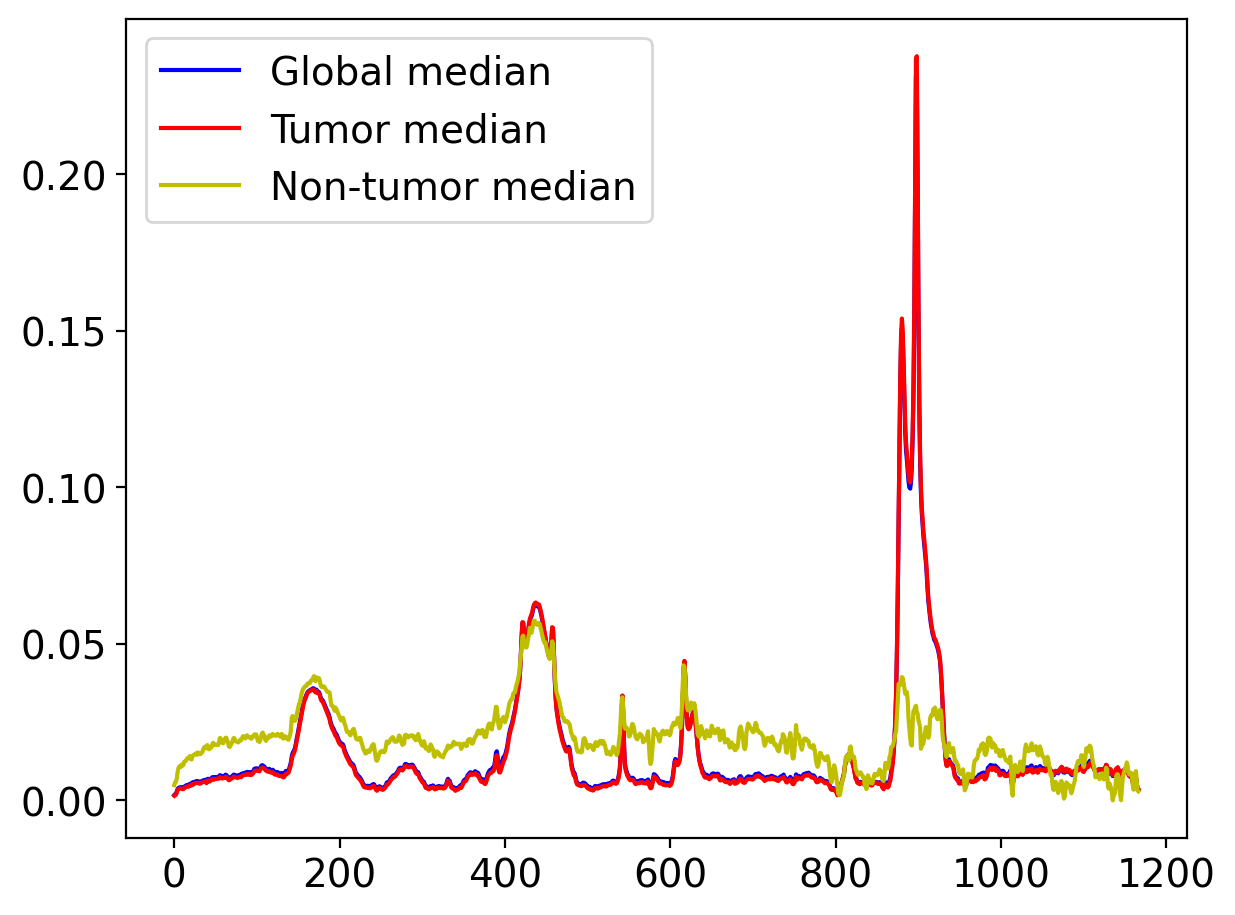

In [17]:
epsilon = 0.28
clusterer = DBSCAN(eps=epsilon)
output_dir_path = os.path.join(CLUSTERING_OUTPUT_DIR, f"dbscan-eps{epsilon}")
run_clustering(clusterer, output_dir_path, paper_fig_export=True)